In [1]:
from gurobipy import *

# Model data
gens,maxGen,Co,a,b,suCo,ruLi,rdLi,ipOut,init=multidict({
'g1':[400.0,100.0,20.0,0.05,300.0,160.0,160.0,0.0,0.0],
'g2':[300.0,200.0,25.0,0.10,400.0,150.0,150.0,0.0,0.0],
'g3':[250.0,300.0,40.0,0.20,500.0,100.0,100.0,0.0,0.0]})

times, demand, reLevel = multidict({
'h1': [260.0, 260.0*0.2],
'h2': [500.0, 500.0*0.2],
'h3': [700.0, 700.0*0.2],
'h4': [300.0, 300.0*0.2]})

# auxiliar list
g2=['g1','g2','g3']
t2=['h1','h2','h3','h4']

In [2]:
# Create optimization model
m = Model('UC')

## Generation per Unit Variables $\quad P_{Gjt} \quad \forall j, \forall t$

In [3]:
# variable for generations per unit per hour
Pg = {}
for g in gens:
    for t in times:
        # 12 variables
        Pg[g,t] = m.addVar(lb=0.0, ub=maxGen[g], name='Pg'+'[%s,%s]'%(g,t))
        # initial value 0.0
        Pg[g,t].start = 0.0     

## Status on/off variables   $\quad u_{jt} = \{0,1\} \quad \forall j, \forall t$

In [4]:
# variable for generations per unit per hour
u = {}
for g in gens:
    for t in times:
        # 12 variables
        u[g,t] = m.addVar(vtype=GRB.BINARY, name='u'+'[%s,%s]'%(g,t))
        # initial value 0
        u[g,t].start = 0    

## StartUp Cost variables $ \quad C_{jt}^{SU} $

In [5]:
su = {}
for g in gens:
    for t in times:
        # 12 variables
        su[g,t] = m.addVar(lb=0.0, name='su'+'[%s,%s]'%(g,t))

## Objective
$$ min \sum_{t=1}^T\sum_{j=1}^n C_{jt}(u_{jt},P_{Gjt})+C_{jt}^{SU}$$

In [6]:
m.setObjective(sum(u[g,t]*Co[g] +
                   a[g]*Pg[g,t] +
                   0.5*b[g]*Pg[g,t]*Pg[g,t] +
                   su[g,t]
                   for g in gens 
                   for t in times), 
                   GRB.MINIMIZE)

## Min-Max Generation Constraint 
$ u_{jt}P_{Gjt}^{min} \le P_{Gjt} \le u_{jt}P_{Gjt}^{max}$

In [7]:
m.addConstrs((Pg[g,t] >= 0.0 
              for g in gens
              for t in times),
              name='pMin')
m.addConstrs((u[g,t]*maxGen[g] >= Pg[g,t]
              for g in gens
              for t in times),
              name='pMax')

{('g1', 'h1'): <gurobi.Constr *Awaiting Model Update*>,
 ('g1', 'h2'): <gurobi.Constr *Awaiting Model Update*>,
 ('g1', 'h3'): <gurobi.Constr *Awaiting Model Update*>,
 ('g1', 'h4'): <gurobi.Constr *Awaiting Model Update*>,
 ('g2', 'h1'): <gurobi.Constr *Awaiting Model Update*>,
 ('g2', 'h2'): <gurobi.Constr *Awaiting Model Update*>,
 ('g2', 'h3'): <gurobi.Constr *Awaiting Model Update*>,
 ('g2', 'h4'): <gurobi.Constr *Awaiting Model Update*>,
 ('g3', 'h1'): <gurobi.Constr *Awaiting Model Update*>,
 ('g3', 'h2'): <gurobi.Constr *Awaiting Model Update*>,
 ('g3', 'h3'): <gurobi.Constr *Awaiting Model Update*>,
 ('g3', 'h4'): <gurobi.Constr *Awaiting Model Update*>}

## Constraint for supply-demand 
$\sum_{j=1}^n P_{Gjt} = P_{Dt} \quad \forall j, \forall t$

In [8]:
m.addConstrs(
    (quicksum(Pg[g,t] for g in gens) == demand[t]
     for t in times), name='meetDemand')

{'h1': <gurobi.Constr *Awaiting Model Update*>,
 'h2': <gurobi.Constr *Awaiting Model Update*>,
 'h3': <gurobi.Constr *Awaiting Model Update*>,
 'h4': <gurobi.Constr *Awaiting Model Update*>}

## Constraint for RampDown 

In [9]:
for g in gens:
    for t in range(4):
        if t == 0:
            continue
        m.addConstr(Pg[g,t2[t-1]] - Pg[g,t2[t]] <= rdLi[g], 
                    name='rampDown'+'[%s,%s]'%(g,t2[t]))

## Constraint for RampUp

In [10]:
for g in gens:
    for t in range(4):
        if t == 0:
            continue
        m.addConstr(Pg[g,t2[t]] - Pg[g,t2[t-1]] <= ruLi[g], 
                    name='rampUp'+'[%s,%s]'%(g,t2[t]))

## Constraint for StartUp Cost

In [11]:
for g in gens:
    for t in range(4):
        s = 'cSUcons'+'[%s,%s]'%(g,t2[t]) 
        if t == 0:
            m.addConstr(su[g,t2[t]] >= suCo[g]*(u[g,t2[t]]), 
                    name = s)
            continue
        m.addConstr(su[g,t2[t]] >= suCo[g]*(u[g,t2[t]] - u[g,t2[t-1]]), 
                    name = s)

## Constraint for Demand + Reserve

In [12]:
m.addConstrs(
    (quicksum(u[g,t] * maxGen[g] for g in gens) >= 
     demand[t] + reLevel[t]
     for t in times), name='dPlusRe')

{'h1': <gurobi.Constr *Awaiting Model Update*>,
 'h2': <gurobi.Constr *Awaiting Model Update*>,
 'h3': <gurobi.Constr *Awaiting Model Update*>,
 'h4': <gurobi.Constr *Awaiting Model Update*>}

In [13]:
m.optimize()

Optimize a model with 62 rows, 36 columns and 129 nonzeros
Model has 12 quadratic objective terms
Variable types: 24 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+00, 3e+02]
  QObjective range [5e-02, 2e-01]
  Bounds range     [1e+00, 4e+02]
  RHS range        [1e+02, 8e+02]
Found heuristic solution: objective 2.40001e+10
Presolve removed 28 rows and 14 columns
Presolve time: 0.01s
Presolved: 34 rows, 22 columns, 96 nonzeros
Presolved model has 12 quadratic objective terms

MIP start did not produce a new incumbent solution
MIP start violates constraint meetDemand[h2] by 500.000000000

Found heuristic solution: objective 4.000062e+09
Variable types: 14 continuous, 8 integer (8 binary)

Root relaxation: objective 5.587137e+04, 37 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5

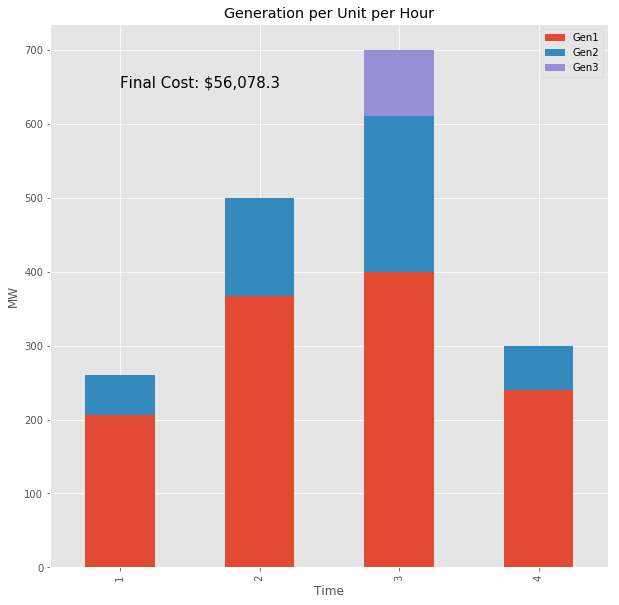

In [14]:
%matplotlib inline
import numpy as np
import matplotlib
import pandas as pd
matplotlib.style.use('ggplot')
a = np.zeros(4)
b = np.zeros(4)
c = np.zeros(4)
for v in m.getVars():
    if v.varName[0:2] == 'Pg':
        if v.varName[3:5] == 'g1':
            a[int(v.varName[7:8])-1] = v.X
        elif v.varName[3:5] == 'g2':
            b[int(v.varName[7:8])-1] = v.X
        else:
            c[int(v.varName[7:8])-1] = v.X
data = [a,b,c]
data = np.asarray(data).T.tolist()
ind = np.arange(1,5)
df2 = pd.DataFrame(data, columns=['Gen1', 'Gen2', 'Gen3'], index=ind)
ax = df2.plot.bar(title ='Generation per Unit per Hour', figsize=(10, 10),stacked=True)
ax.set_xlabel("Time")
ax.set_ylabel("MW")
ax.text(0, 650, 'Final Cost: $'+"{0:,.1f}".format(m.objVal), fontsize=15)

In [15]:
# print(gens)
# print(gen['gen3'].getAttr('UB'))

#print(m.getObjective())
# print(m.getConstrs())
# print(m.getConstrs()[25])
# print(m.getConstrs()[25].getAttr('sense'))
# print(m.getConstrs()[25].getAttr('rhs'))

# print reLevel

# #number of variables
# print(m.numVars)

# print(maxGen['gen2'])
# print(m.numVars)
# print(genPhour)
# print(genPhour['gen3','hour1'].getAttr('UB'))
# print(genPhour['gen3','hour1'].getAttr('start'))
# print(ujt['gen3','hour1'].getAttr('LB'))

#variable for generations per unit
#gen = m.addVars(gens, lb=0.0, ub=maxGen, name='gen')

# m.addConstrs(
# (quicksum(nutritionValues[f,c] * buy[f] for f in foods) == nutrition[c]
# for c in categories), "_")

# for t in range(4):
#     if t2[t-1] == 'h5':
#         print('t ' + t2[t])
#         print('t-1 0')
#         continue
#     print('t ' + t2[t])
#     print('t-1 ' + t2[t-1])

#             m.addConstr(0.0 - Pg[g,t2[t]] <= rdLi[g],
#                         name='rampDown'+'[%s,%s]'%(g,t2[t]))